### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 20  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:14<103:26:40, 74.50s/it]

Entrenando:   0%|          | 2/5000 [02:27<102:19:54, 73.71s/it]

Entrenando:   0%|          | 3/5000 [03:40<101:58:48, 73.47s/it]

Entrenando:   0%|          | 4/5000 [04:54<102:16:04, 73.69s/it]

Entrenando:   0%|          | 5/5000 [06:07<101:46:55, 73.36s/it]

Entrenando:   0%|          | 6/5000 [07:21<101:53:43, 73.45s/it]

Entrenando:   0%|          | 7/5000 [08:34<101:39:54, 73.30s/it]

Entrenando:   0%|          | 8/5000 [09:47<101:32:42, 73.23s/it]

Entrenando:   0%|          | 9/5000 [11:01<101:57:18, 73.54s/it]

Entrenando:   0%|          | 10/5000 [12:14<101:47:41, 73.44s/it]

Entrenando:   0%|          | 11/5000 [13:31<103:15:04, 74.50s/it]

Entrenando:   0%|          | 12/5000 [15:08<112:34:08, 81.24s/it]

Entrenando:   0%|          | 13/5000 [17:01<125:59:35, 90.95s/it]

Entrenando:   0%|          | 14/5000 [18:55<135:32:42, 97.87s/it]

Entrenando:   0%|          | 15/5000 [20:45<140:38:22, 101.57s/it]

Entrenando:   0%|          | 16/5000 [22:39<145:36:12, 105.17s/it]

Entrenando:   0%|          | 17/5000 [24:30<148:17:27, 107.13s/it]

Entrenando:   0%|          | 18/5000 [26:31<154:00:52, 111.29s/it]

Entrenando:   0%|          | 19/5000 [28:31<157:20:01, 113.71s/it]

Entrenando:   0%|          | 20/5000 [31:22<181:19:41, 131.08s/it]

Entrenando:   0%|          | 21/5000 [34:35<206:56:08, 149.62s/it]

Entrenando:   0%|          | 22/5000 [37:40<221:20:06, 160.07s/it]

Entrenando:   0%|          | 23/5000 [40:39<229:12:48, 165.80s/it]

Entrenando:   0%|          | 24/5000 [43:53<241:05:21, 174.42s/it]

Entrenando:   0%|          | 25/5000 [46:51<242:22:35, 175.39s/it]

Entrenando:   1%|          | 26/5000 [49:48<243:04:47, 175.93s/it]

Entrenando:   1%|          | 27/5000 [53:44<267:58:35, 193.99s/it]

Entrenando:   1%|          | 28/5000 [57:51<289:39:02, 209.72s/it]

Entrenando:   1%|          | 29/5000 [1:02:14<311:51:33, 225.85s/it]

Entrenando:   1%|          | 30/5000 [1:06:36<326:42:43, 236.65s/it]

Entrenando:   1%|          | 31/5000 [1:10:49<333:19:24, 241.49s/it]

Entrenando:   1%|          | 32/5000 [1:15:08<340:36:02, 246.81s/it]

Entrenando:   1%|          | 33/5000 [1:19:20<342:36:20, 248.31s/it]

Entrenando:   1%|          | 34/5000 [1:23:26<341:30:49, 247.57s/it]

Entrenando:   1%|          | 35/5000 [1:27:28<339:26:57, 246.13s/it]

Entrenando:   1%|          | 36/5000 [1:31:30<337:39:34, 244.88s/it]

Entrenando:   1%|          | 37/5000 [1:35:31<335:46:49, 243.56s/it]

Entrenando:   1%|          | 38/5000 [1:39:34<335:36:04, 243.48s/it]

Entrenando:   1%|          | 39/5000 [1:43:19<327:59:31, 238.01s/it]

Entrenando:   1%|          | 40/5000 [1:47:01<321:14:56, 233.16s/it]

Entrenando:   1%|          | 41/5000 [1:50:32<311:46:36, 226.34s/it]

Entrenando:   1%|          | 42/5000 [1:53:44<297:33:32, 216.06s/it]

Entrenando:   1%|          | 43/5000 [1:56:37<279:52:01, 203.25s/it]

Entrenando:   1%|          | 44/5000 [1:59:49<275:14:18, 199.93s/it]

Entrenando:   1%|          | 45/5000 [2:03:05<273:36:40, 198.79s/it]

Entrenando:   1%|          | 46/5000 [2:06:04<265:02:39, 192.60s/it]

Entrenando:   1%|          | 47/5000 [2:09:02<259:18:33, 188.47s/it]

Entrenando:   1%|          | 48/5000 [2:11:54<252:16:44, 183.40s/it]

Entrenando:   1%|          | 49/5000 [2:14:53<250:28:56, 182.13s/it]

Entrenando:   1%|          | 50/5000 [2:17:59<252:01:32, 183.29s/it]

Iter  50: train_loss=4.3399, val_loss=4.3051, train_suc=0.672, train_err=0.174, train_inc=0.154 | val_suc=0.654, val_err=0.182, val_inc=0.164


Entrenando:   1%|          | 51/5000 [2:21:06<253:27:05, 184.37s/it]

Entrenando:   1%|          | 52/5000 [2:24:03<250:22:10, 182.16s/it]

Entrenando:   1%|          | 53/5000 [2:26:53<245:21:06, 178.55s/it]

Entrenando:   1%|          | 54/5000 [2:29:36<239:02:17, 173.99s/it]

Entrenando:   1%|          | 55/5000 [2:32:19<234:06:07, 170.43s/it]

Entrenando:   1%|          | 56/5000 [2:34:51<226:44:35, 165.10s/it]

Entrenando:   1%|          | 57/5000 [2:37:22<220:41:11, 160.73s/it]

Entrenando:   1%|          | 58/5000 [2:39:51<216:03:31, 157.39s/it]

Entrenando:   1%|          | 59/5000 [2:42:15<210:32:07, 153.40s/it]

Entrenando:   1%|          | 60/5000 [2:44:36<205:09:38, 149.51s/it]

Entrenando:   1%|          | 61/5000 [2:46:46<197:07:43, 143.69s/it]

Entrenando:   1%|          | 62/5000 [2:48:48<188:02:31, 137.09s/it]

Entrenando:   1%|▏         | 63/5000 [2:50:42<178:33:09, 130.20s/it]

Entrenando:   1%|▏         | 64/5000 [2:52:37<172:15:29, 125.63s/it]

Entrenando:   1%|▏         | 65/5000 [2:54:34<168:32:42, 122.95s/it]

Entrenando:   1%|▏         | 66/5000 [2:56:56<176:27:05, 128.74s/it]

Entrenando:   1%|▏         | 67/5000 [2:58:59<174:18:19, 127.20s/it]

Entrenando:   1%|▏         | 68/5000 [3:01:04<173:13:31, 126.44s/it]

Entrenando:   1%|▏         | 69/5000 [3:03:19<176:33:11, 128.90s/it]

Entrenando:   1%|▏         | 70/5000 [3:05:27<176:19:32, 128.76s/it]

Entrenando:   1%|▏         | 71/5000 [3:07:38<177:19:13, 129.51s/it]

Entrenando:   1%|▏         | 72/5000 [3:09:40<174:09:48, 127.23s/it]

Entrenando:   1%|▏         | 73/5000 [3:11:40<171:13:36, 125.11s/it]

Entrenando:   1%|▏         | 74/5000 [3:13:37<167:47:14, 122.62s/it]

Entrenando:   2%|▏         | 75/5000 [3:15:37<166:22:31, 121.61s/it]

Entrenando:   2%|▏         | 76/5000 [3:17:43<168:15:33, 123.02s/it]

Entrenando:   2%|▏         | 77/5000 [3:19:48<168:56:42, 123.54s/it]

Entrenando:   2%|▏         | 78/5000 [3:21:47<167:17:24, 122.36s/it]

Entrenando:   2%|▏         | 79/5000 [3:23:56<170:02:41, 124.40s/it]

Entrenando:   2%|▏         | 80/5000 [3:26:10<173:49:10, 127.19s/it]

Entrenando:   2%|▏         | 81/5000 [3:28:13<172:13:00, 126.04s/it]

Entrenando:   2%|▏         | 82/5000 [3:30:19<171:53:15, 125.82s/it]

Entrenando:   2%|▏         | 83/5000 [3:32:11<166:14:45, 121.72s/it]

Entrenando:   2%|▏         | 84/5000 [3:34:12<165:52:15, 121.47s/it]

Entrenando:   2%|▏         | 85/5000 [3:36:10<164:33:18, 120.53s/it]

Entrenando:   2%|▏         | 86/5000 [3:38:16<166:43:47, 122.15s/it]

Entrenando:   2%|▏         | 87/5000 [3:40:23<168:48:06, 123.69s/it]

Entrenando:   2%|▏         | 88/5000 [3:42:29<169:40:58, 124.36s/it]

Entrenando:   2%|▏         | 89/5000 [3:44:30<168:20:51, 123.41s/it]

Entrenando:   2%|▏         | 90/5000 [3:46:39<170:32:16, 125.04s/it]

Entrenando:   2%|▏         | 91/5000 [3:48:40<168:33:21, 123.61s/it]

Entrenando:   2%|▏         | 92/5000 [3:50:44<168:46:22, 123.79s/it]

Entrenando:   2%|▏         | 93/5000 [3:52:58<173:12:05, 127.07s/it]

Entrenando:   2%|▏         | 94/5000 [3:54:56<169:12:17, 124.16s/it]

Entrenando:   2%|▏         | 95/5000 [3:56:56<167:41:23, 123.08s/it]

Entrenando:   2%|▏         | 96/5000 [3:59:02<168:47:47, 123.91s/it]

Entrenando:   2%|▏         | 97/5000 [4:01:15<172:17:46, 126.51s/it]

Entrenando:   2%|▏         | 98/5000 [4:03:11<168:14:06, 123.55s/it]

Entrenando:   2%|▏         | 99/5000 [4:05:16<168:28:15, 123.75s/it]

Entrenando:   2%|▏         | 100/5000 [4:07:18<167:52:24, 123.34s/it]

Iter 100: train_loss=2.0500, val_loss=2.0356, train_suc=0.682, train_err=0.055, train_inc=0.263 | val_suc=0.663, val_err=0.057, val_inc=0.280
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:09:10<163:19:19, 120.02s/it]

Entrenando:   2%|▏         | 102/5000 [4:11:10<163:13:25, 119.97s/it]

Entrenando:   2%|▏         | 103/5000 [4:13:25<169:04:50, 124.30s/it]

Entrenando:   2%|▏         | 104/5000 [4:15:35<171:43:41, 126.27s/it]

Entrenando:   2%|▏         | 105/5000 [4:17:37<169:38:16, 124.76s/it]

Entrenando:   2%|▏         | 106/5000 [4:19:29<164:40:22, 121.13s/it]

Entrenando:   2%|▏         | 107/5000 [4:21:24<162:10:30, 119.32s/it]

Entrenando:   2%|▏         | 108/5000 [4:23:32<165:30:48, 121.80s/it]

Entrenando:   2%|▏         | 109/5000 [4:25:37<166:40:59, 122.69s/it]

Entrenando:   2%|▏         | 110/5000 [4:27:40<167:00:30, 122.95s/it]

Entrenando:   2%|▏         | 111/5000 [4:29:41<165:59:07, 122.22s/it]

Entrenando:   2%|▏         | 112/5000 [4:31:36<163:05:46, 120.12s/it]

Entrenando:   2%|▏         | 113/5000 [4:33:44<166:13:40, 122.45s/it]

Entrenando:   2%|▏         | 114/5000 [4:35:48<166:57:54, 123.02s/it]

Entrenando:   2%|▏         | 115/5000 [4:37:51<166:55:08, 123.01s/it]

Entrenando:   2%|▏         | 116/5000 [4:40:03<170:18:31, 125.53s/it]

Entrenando:   2%|▏         | 117/5000 [4:42:09<170:45:54, 125.90s/it]

Entrenando:   2%|▏         | 118/5000 [4:44:25<174:50:35, 128.93s/it]

Entrenando:   2%|▏         | 119/5000 [4:46:38<176:12:43, 129.97s/it]

Entrenando:   2%|▏         | 120/5000 [4:48:55<179:03:50, 132.10s/it]

Entrenando:   2%|▏         | 121/5000 [4:50:56<174:31:02, 128.77s/it]

Entrenando:   2%|▏         | 122/5000 [4:53:12<177:27:04, 130.96s/it]

Entrenando:   2%|▏         | 123/5000 [4:55:26<178:34:25, 131.82s/it]

Entrenando:   2%|▏         | 124/5000 [4:57:31<175:38:58, 129.68s/it]

Entrenando:   2%|▎         | 125/5000 [4:59:23<168:45:54, 124.63s/it]

Entrenando:   3%|▎         | 126/5000 [5:01:31<169:46:59, 125.40s/it]

Entrenando:   3%|▎         | 127/5000 [5:03:44<172:58:07, 127.78s/it]

Entrenando:   3%|▎         | 128/5000 [5:05:46<170:33:11, 126.02s/it]

Entrenando:   3%|▎         | 129/5000 [5:07:57<172:39:29, 127.61s/it]

Entrenando:   3%|▎         | 130/5000 [5:11:02<195:49:59, 144.76s/it]

Entrenando:   3%|▎         | 131/5000 [5:14:41<226:01:07, 167.11s/it]

Entrenando:   3%|▎         | 132/5000 [5:18:16<245:11:16, 181.32s/it]

Entrenando:   3%|▎         | 133/5000 [5:21:58<261:58:32, 193.78s/it]

Entrenando:   3%|▎         | 134/5000 [5:25:37<271:48:18, 201.09s/it]

Entrenando:   3%|▎         | 135/5000 [5:29:08<276:05:08, 204.30s/it]

Entrenando:   3%|▎         | 136/5000 [5:32:53<284:24:39, 210.50s/it]

Entrenando:   3%|▎         | 137/5000 [5:36:42<291:29:41, 215.79s/it]

Entrenando:   3%|▎         | 138/5000 [5:40:32<297:14:02, 220.08s/it]

Entrenando:   3%|▎         | 139/5000 [5:44:26<303:04:47, 224.46s/it]

Entrenando:   3%|▎         | 140/5000 [5:48:16<305:03:54, 225.97s/it]

Entrenando:   3%|▎         | 141/5000 [5:52:05<306:07:52, 226.81s/it]

Entrenando:   3%|▎         | 142/5000 [5:55:54<306:55:55, 227.45s/it]

Entrenando:   3%|▎         | 143/5000 [5:59:45<308:20:19, 228.54s/it]

Entrenando:   3%|▎         | 144/5000 [6:03:33<308:12:13, 228.49s/it]

Entrenando:   3%|▎         | 145/5000 [6:07:22<308:33:22, 228.80s/it]

Entrenando:   3%|▎         | 146/5000 [6:11:09<307:31:02, 228.07s/it]

Entrenando:   3%|▎         | 147/5000 [6:15:01<309:12:37, 229.38s/it]

Entrenando:   3%|▎         | 148/5000 [6:18:49<308:38:17, 229.00s/it]

Entrenando:   3%|▎         | 149/5000 [6:22:35<307:11:58, 227.98s/it]

Entrenando:   3%|▎         | 150/5000 [6:26:05<299:43:35, 222.48s/it]

Iter 150: train_loss=1.0314, val_loss=0.9811, train_suc=0.705, train_err=0.002, train_inc=0.293 | val_suc=0.687, val_err=0.002, val_inc=0.311


Entrenando:   3%|▎         | 151/5000 [6:29:10<284:45:20, 211.41s/it]

Entrenando:   3%|▎         | 152/5000 [6:32:08<271:09:59, 201.36s/it]

Entrenando:   3%|▎         | 153/5000 [6:35:10<263:16:09, 195.54s/it]

Entrenando:   3%|▎         | 154/5000 [6:38:22<261:54:27, 194.57s/it]

Entrenando:   3%|▎         | 155/5000 [6:41:31<259:32:15, 192.85s/it]

Entrenando:   3%|▎         | 156/5000 [6:44:31<254:22:21, 189.05s/it]

Entrenando:   3%|▎         | 157/5000 [6:47:24<247:35:57, 184.05s/it]

Entrenando:   3%|▎         | 158/5000 [6:50:13<241:35:16, 179.62s/it]

Entrenando:   3%|▎         | 159/5000 [6:52:49<232:05:17, 172.59s/it]

Entrenando:   3%|▎         | 160/5000 [6:55:20<223:22:29, 166.15s/it]

Entrenando:   3%|▎         | 161/5000 [6:57:51<216:58:44, 161.42s/it]

Entrenando:   3%|▎         | 162/5000 [7:00:21<212:31:58, 158.15s/it]

Entrenando:   3%|▎         | 163/5000 [7:02:53<209:50:41, 156.18s/it]

Entrenando:   3%|▎         | 164/5000 [7:05:17<204:48:41, 152.47s/it]

Entrenando:   3%|▎         | 165/5000 [7:07:37<199:54:31, 148.85s/it]

Entrenando:   3%|▎         | 166/5000 [7:09:56<195:49:51, 145.84s/it]

Entrenando:   3%|▎         | 167/5000 [7:12:13<192:25:30, 143.33s/it]

Entrenando:   3%|▎         | 168/5000 [7:14:31<190:03:21, 141.60s/it]

Entrenando:   3%|▎         | 169/5000 [7:16:38<184:15:24, 137.31s/it]

Entrenando:   3%|▎         | 170/5000 [7:18:46<180:35:20, 134.60s/it]

Entrenando:   3%|▎         | 171/5000 [7:20:52<176:57:35, 131.92s/it]

Entrenando:   3%|▎         | 172/5000 [7:23:07<177:55:32, 132.67s/it]

Entrenando:   3%|▎         | 173/5000 [7:25:20<178:16:29, 132.96s/it]

Entrenando:   3%|▎         | 174/5000 [7:27:34<178:44:29, 133.33s/it]

Entrenando:   4%|▎         | 175/5000 [7:29:57<182:22:28, 136.07s/it]

Entrenando:   4%|▎         | 176/5000 [7:32:13<182:22:44, 136.10s/it]

Entrenando:   4%|▎         | 177/5000 [7:34:33<183:51:43, 137.24s/it]

Entrenando:   4%|▎         | 178/5000 [7:36:49<183:18:38, 136.86s/it]

Entrenando:   4%|▎         | 179/5000 [7:39:03<182:05:23, 135.97s/it]

Entrenando:   4%|▎         | 180/5000 [7:41:22<183:21:12, 136.94s/it]

Entrenando:   4%|▎         | 181/5000 [7:43:44<185:11:37, 138.35s/it]

Entrenando:   4%|▎         | 182/5000 [7:45:52<181:04:27, 135.30s/it]

Entrenando:   4%|▎         | 183/5000 [7:47:54<175:37:34, 131.25s/it]

Entrenando:   4%|▎         | 184/5000 [7:49:58<172:37:04, 129.03s/it]

Entrenando:   4%|▎         | 185/5000 [7:51:53<167:07:43, 124.96s/it]

Entrenando:   4%|▎         | 186/5000 [7:53:47<162:54:56, 121.83s/it]

Entrenando:   4%|▎         | 187/5000 [7:56:01<167:31:28, 125.30s/it]

Entrenando:   4%|▍         | 188/5000 [7:57:59<164:47:13, 123.28s/it]

Entrenando:   4%|▍         | 189/5000 [7:59:58<163:01:49, 121.99s/it]

Entrenando:   4%|▍         | 190/5000 [8:02:08<165:56:19, 124.20s/it]

Entrenando:   4%|▍         | 191/5000 [8:04:16<167:42:49, 125.55s/it]

Entrenando:   4%|▍         | 192/5000 [8:06:18<166:14:29, 124.47s/it]

Entrenando:   4%|▍         | 193/5000 [8:08:29<168:46:03, 126.39s/it]

Entrenando:   4%|▍         | 194/5000 [8:10:38<169:47:34, 127.19s/it]

Entrenando:   4%|▍         | 195/5000 [8:12:51<171:53:26, 128.78s/it]

Entrenando:   4%|▍         | 196/5000 [8:14:55<170:06:51, 127.48s/it]

Entrenando:   4%|▍         | 197/5000 [8:16:57<167:42:32, 125.70s/it]

Entrenando:   4%|▍         | 198/5000 [8:19:10<170:32:38, 127.85s/it]

Entrenando:   4%|▍         | 199/5000 [8:21:19<171:10:23, 128.35s/it]

Entrenando:   4%|▍         | 200/5000 [8:23:30<172:05:08, 129.06s/it]

Iter 200: train_loss=0.8498, val_loss=0.8389, train_suc=0.738, train_err=0.000, train_inc=0.262 | val_suc=0.722, val_err=0.000, val_inc=0.278
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:25:33<169:39:01, 127.26s/it]

Entrenando:   4%|▍         | 202/5000 [8:27:50<173:32:28, 130.21s/it]

Entrenando:   4%|▍         | 203/5000 [8:30:10<177:18:16, 133.06s/it]

Entrenando:   4%|▍         | 204/5000 [8:32:27<179:00:38, 134.37s/it]

Entrenando:   4%|▍         | 205/5000 [8:34:45<180:09:23, 135.26s/it]

Entrenando:   4%|▍         | 206/5000 [8:37:02<180:46:31, 135.75s/it]

Entrenando:   4%|▍         | 207/5000 [8:40:04<199:24:49, 149.78s/it]

Entrenando:   4%|▍         | 208/5000 [8:43:10<213:55:56, 160.72s/it]

Entrenando:   4%|▍         | 209/5000 [8:46:20<225:37:55, 169.54s/it]

Entrenando:   4%|▍         | 210/5000 [8:49:35<235:40:17, 177.12s/it]

Entrenando:   4%|▍         | 211/5000 [8:52:40<238:51:04, 179.55s/it]

Entrenando:   4%|▍         | 212/5000 [8:55:42<239:28:11, 180.05s/it]

Entrenando:   4%|▍         | 213/5000 [8:58:40<238:33:38, 179.41s/it]

Entrenando:   4%|▍         | 214/5000 [9:01:43<240:16:56, 180.74s/it]

Entrenando:   4%|▍         | 215/5000 [9:04:42<239:26:08, 180.14s/it]

Entrenando:   4%|▍         | 216/5000 [9:07:52<243:15:34, 183.05s/it]

Entrenando:   4%|▍         | 217/5000 [9:10:53<242:30:20, 182.53s/it]

Entrenando:   4%|▍         | 218/5000 [9:13:51<240:31:38, 181.07s/it]

Entrenando:   4%|▍         | 219/5000 [9:17:00<243:46:08, 183.55s/it]

Entrenando:   4%|▍         | 220/5000 [9:20:34<255:44:11, 192.60s/it]

Entrenando:   4%|▍         | 221/5000 [9:23:58<260:19:21, 196.10s/it]

Entrenando:   4%|▍         | 222/5000 [9:27:08<257:38:54, 194.13s/it]

Entrenando:   4%|▍         | 223/5000 [9:30:07<251:31:31, 189.55s/it]

Entrenando:   4%|▍         | 224/5000 [9:33:15<251:00:33, 189.20s/it]

Entrenando:   4%|▍         | 225/5000 [9:36:37<256:02:06, 193.03s/it]

Entrenando:   5%|▍         | 226/5000 [9:39:45<253:54:09, 191.46s/it]

Entrenando:   5%|▍         | 227/5000 [9:42:45<249:14:35, 187.99s/it]

Entrenando:   5%|▍         | 228/5000 [9:45:39<243:34:31, 183.75s/it]

Entrenando:   5%|▍         | 229/5000 [9:48:55<248:32:26, 187.54s/it]

Entrenando:   5%|▍         | 230/5000 [9:51:54<244:55:12, 184.85s/it]

Entrenando:   5%|▍         | 231/5000 [9:54:56<244:02:36, 184.22s/it]

Entrenando:   5%|▍         | 232/5000 [9:57:56<242:03:51, 182.77s/it]

Entrenando:   5%|▍         | 233/5000 [10:00:56<240:57:06, 181.96s/it]

Entrenando:   5%|▍         | 234/5000 [10:03:52<238:26:02, 180.10s/it]

Entrenando:   5%|▍         | 235/5000 [10:06:59<241:26:14, 182.41s/it]

Entrenando:   5%|▍         | 236/5000 [10:09:49<236:19:18, 178.58s/it]

Entrenando:   5%|▍         | 237/5000 [10:12:42<233:53:01, 176.78s/it]

Entrenando:   5%|▍         | 238/5000 [10:15:37<233:16:47, 176.36s/it]

Entrenando:   5%|▍         | 239/5000 [10:18:36<234:19:44, 177.19s/it]

Entrenando:   5%|▍         | 240/5000 [10:21:33<234:09:20, 177.09s/it]

Entrenando:   5%|▍         | 241/5000 [10:24:20<230:09:05, 174.10s/it]

Entrenando:   5%|▍         | 242/5000 [10:27:12<229:10:05, 173.39s/it]

Entrenando:   5%|▍         | 243/5000 [10:30:13<232:25:34, 175.90s/it]

Entrenando:   5%|▍         | 244/5000 [10:33:14<234:16:49, 177.34s/it]

Entrenando:   5%|▍         | 245/5000 [10:36:16<235:57:04, 178.64s/it]

Entrenando:   5%|▍         | 246/5000 [10:39:16<236:31:40, 179.11s/it]

Entrenando:   5%|▍         | 247/5000 [10:42:22<239:18:17, 181.25s/it]

Entrenando:   5%|▍         | 248/5000 [10:45:15<235:50:59, 178.67s/it]

Entrenando:   5%|▍         | 249/5000 [10:48:18<237:34:00, 180.01s/it]

Entrenando:   5%|▌         | 250/5000 [10:51:08<233:38:49, 177.08s/it]

Iter 250: train_loss=0.7290, val_loss=0.7726, train_suc=0.757, train_err=0.000, train_inc=0.242 | val_suc=0.743, val_err=0.000, val_inc=0.256


Entrenando:   5%|▌         | 251/5000 [10:53:55<229:32:35, 174.01s/it]

Entrenando:   5%|▌         | 252/5000 [10:57:07<236:41:23, 179.46s/it]

Entrenando:   5%|▌         | 253/5000 [10:59:53<231:07:03, 175.27s/it]

Entrenando:   5%|▌         | 254/5000 [11:02:54<233:19:00, 176.98s/it]

Entrenando:   5%|▌         | 255/5000 [11:05:49<232:31:30, 176.42s/it]

Entrenando:   5%|▌         | 256/5000 [11:08:39<229:55:40, 174.48s/it]

Entrenando:   5%|▌         | 257/5000 [11:11:33<229:36:22, 174.27s/it]

Entrenando:   5%|▌         | 258/5000 [11:14:27<229:40:04, 174.36s/it]

Entrenando:   5%|▌         | 259/5000 [11:17:16<227:16:01, 172.57s/it]

Entrenando:   5%|▌         | 260/5000 [11:20:19<231:23:34, 175.74s/it]

Entrenando:   5%|▌         | 261/5000 [11:23:06<228:08:47, 173.31s/it]

Entrenando:   5%|▌         | 262/5000 [11:25:54<225:43:57, 171.51s/it]

Entrenando:   5%|▌         | 263/5000 [11:28:51<227:59:34, 173.27s/it]

Entrenando:   5%|▌         | 264/5000 [11:31:40<226:14:23, 171.97s/it]

Entrenando:   5%|▌         | 265/5000 [11:34:27<224:11:04, 170.45s/it]

Entrenando:   5%|▌         | 266/5000 [11:37:30<229:17:31, 174.37s/it]

Entrenando:   5%|▌         | 267/5000 [11:40:37<234:06:58, 178.07s/it]

Entrenando:   5%|▌         | 268/5000 [11:43:35<233:46:12, 177.85s/it]

Entrenando:   5%|▌         | 269/5000 [11:46:31<233:06:35, 177.38s/it]

Entrenando:   5%|▌         | 270/5000 [11:49:22<230:33:38, 175.48s/it]

Entrenando:   5%|▌         | 271/5000 [11:52:09<227:10:11, 172.94s/it]

Entrenando:   5%|▌         | 272/5000 [11:54:57<225:03:22, 171.36s/it]

Entrenando:   5%|▌         | 273/5000 [11:57:46<224:15:44, 170.79s/it]

Entrenando:   5%|▌         | 274/5000 [12:00:43<226:32:00, 172.56s/it]

Entrenando:   6%|▌         | 275/5000 [12:03:52<233:09:30, 177.64s/it]

Entrenando:   6%|▌         | 276/5000 [12:06:45<231:10:14, 176.17s/it]

Entrenando:   6%|▌         | 277/5000 [12:09:41<230:57:31, 176.04s/it]

Entrenando:   6%|▌         | 278/5000 [12:12:28<227:25:10, 173.38s/it]

Entrenando:   6%|▌         | 279/5000 [12:15:25<228:58:02, 174.60s/it]

Entrenando:   6%|▌         | 280/5000 [12:18:14<226:33:22, 172.80s/it]

Entrenando:   6%|▌         | 281/5000 [12:21:18<231:02:52, 176.26s/it]

Entrenando:   6%|▌         | 282/5000 [12:24:19<232:49:57, 177.66s/it]

Entrenando:   6%|▌         | 283/5000 [12:27:39<241:30:46, 184.32s/it]

Entrenando:   6%|▌         | 284/5000 [12:30:41<240:29:20, 183.58s/it]

Entrenando:   6%|▌         | 285/5000 [12:33:45<240:30:32, 183.63s/it]

Entrenando:   6%|▌         | 286/5000 [12:36:34<234:54:32, 179.40s/it]

Entrenando:   6%|▌         | 287/5000 [12:39:24<231:13:33, 176.62s/it]

Entrenando:   6%|▌         | 288/5000 [12:42:14<228:21:42, 174.47s/it]

Entrenando:   6%|▌         | 289/5000 [12:45:09<228:44:57, 174.80s/it]

Entrenando:   6%|▌         | 290/5000 [12:48:01<227:25:14, 173.82s/it]

Entrenando:   6%|▌         | 291/5000 [12:50:59<229:01:00, 175.08s/it]

Entrenando:   6%|▌         | 292/5000 [12:53:49<226:51:56, 173.47s/it]

Entrenando:   6%|▌         | 293/5000 [12:56:42<226:39:55, 173.36s/it]

Entrenando:   6%|▌         | 294/5000 [12:59:37<227:26:48, 173.99s/it]

Entrenando:   6%|▌         | 295/5000 [13:03:00<238:38:26, 182.59s/it]

Entrenando:   6%|▌         | 296/5000 [13:05:52<234:39:29, 179.59s/it]

Entrenando:   6%|▌         | 297/5000 [13:08:50<233:43:11, 178.91s/it]

Entrenando:   6%|▌         | 298/5000 [13:11:49<233:56:25, 179.11s/it]

Entrenando:   6%|▌         | 299/5000 [13:14:52<235:24:27, 180.27s/it]

Entrenando:   6%|▌         | 300/5000 [13:17:49<234:06:42, 179.32s/it]

Iter 300: train_loss=0.7504, val_loss=0.7506, train_suc=0.764, train_err=0.000, train_inc=0.235 | val_suc=0.751, val_err=0.000, val_inc=0.249
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [13:20:49<234:22:36, 179.56s/it]

Entrenando:   6%|▌         | 302/5000 [13:23:47<233:36:43, 179.01s/it]

Entrenando:   6%|▌         | 303/5000 [13:26:41<231:31:50, 177.46s/it]

Entrenando:   6%|▌         | 304/5000 [13:29:35<230:16:31, 176.53s/it]

Entrenando:   6%|▌         | 305/5000 [13:32:25<227:37:38, 174.54s/it]

Entrenando:   6%|▌         | 306/5000 [13:35:29<231:18:48, 177.40s/it]

Entrenando:   6%|▌         | 307/5000 [13:38:38<235:46:48, 180.87s/it]

Entrenando:   6%|▌         | 308/5000 [13:41:34<233:53:11, 179.45s/it]

Entrenando:   6%|▌         | 309/5000 [13:44:26<230:44:49, 177.08s/it]

Entrenando:   6%|▌         | 310/5000 [13:47:27<232:05:11, 178.15s/it]

Entrenando:   6%|▌         | 311/5000 [13:50:27<232:58:57, 178.87s/it]

Entrenando:   6%|▌         | 312/5000 [13:53:39<237:59:10, 182.75s/it]

Entrenando:   6%|▋         | 313/5000 [13:56:44<238:52:11, 183.47s/it]

Entrenando:   6%|▋         | 314/5000 [13:59:45<237:50:27, 182.72s/it]

Entrenando:   6%|▋         | 315/5000 [14:03:01<242:47:53, 186.57s/it]

Entrenando:   6%|▋         | 316/5000 [14:06:37<254:13:23, 195.39s/it]

Entrenando:   6%|▋         | 317/5000 [14:09:54<254:53:56, 195.95s/it]

Entrenando:   6%|▋         | 318/5000 [14:12:59<250:31:19, 192.63s/it]

Entrenando:   6%|▋         | 319/5000 [14:16:00<245:57:09, 189.15s/it]

Entrenando:   6%|▋         | 320/5000 [14:18:50<238:34:42, 183.52s/it]

Entrenando:   6%|▋         | 321/5000 [14:21:40<233:02:56, 179.31s/it]

Entrenando:   6%|▋         | 322/5000 [14:24:59<240:52:09, 185.36s/it]

Entrenando:   6%|▋         | 323/5000 [14:28:06<241:27:58, 185.86s/it]

Entrenando:   6%|▋         | 324/5000 [14:31:15<242:29:55, 186.70s/it]

Entrenando:   6%|▋         | 325/5000 [14:34:16<240:27:39, 185.17s/it]

Entrenando:   7%|▋         | 326/5000 [14:37:11<236:25:57, 182.10s/it]

Entrenando:   7%|▋         | 327/5000 [14:40:14<236:24:48, 182.13s/it]

Entrenando:   7%|▋         | 328/5000 [14:43:32<242:51:10, 187.13s/it]

Entrenando:   7%|▋         | 329/5000 [14:46:25<237:03:15, 182.70s/it]

Entrenando:   7%|▋         | 330/5000 [14:49:25<235:50:23, 181.80s/it]

Entrenando:   7%|▋         | 331/5000 [14:52:29<236:58:31, 182.72s/it]

Entrenando:   7%|▋         | 332/5000 [14:55:39<239:39:55, 184.83s/it]

Entrenando:   7%|▋         | 333/5000 [14:58:38<237:16:00, 183.02s/it]

Entrenando:   7%|▋         | 334/5000 [15:01:48<240:00:13, 185.17s/it]

Entrenando:   7%|▋         | 335/5000 [15:04:56<241:04:09, 186.03s/it]

Entrenando:   7%|▋         | 336/5000 [15:08:03<241:22:19, 186.31s/it]

Entrenando:   7%|▋         | 337/5000 [15:10:58<237:00:43, 182.98s/it]

Entrenando:   7%|▋         | 338/5000 [15:13:54<234:02:58, 180.73s/it]

Entrenando:   7%|▋         | 339/5000 [15:16:49<232:00:57, 179.20s/it]

Entrenando:   7%|▋         | 340/5000 [15:20:01<236:47:06, 182.92s/it]

Entrenando:   7%|▋         | 341/5000 [15:23:03<236:31:03, 182.76s/it]

Entrenando:   7%|▋         | 342/5000 [15:25:56<232:42:40, 179.85s/it]

Entrenando:   7%|▋         | 343/5000 [15:29:11<238:27:38, 184.34s/it]

Entrenando:   7%|▋         | 344/5000 [15:32:21<240:19:41, 185.82s/it]

Entrenando:   7%|▋         | 345/5000 [15:35:36<243:57:35, 188.67s/it]

Entrenando:   7%|▋         | 346/5000 [15:39:03<251:13:18, 194.33s/it]

Entrenando:   7%|▋         | 347/5000 [15:42:12<248:46:37, 192.48s/it]

Entrenando:   7%|▋         | 348/5000 [15:45:13<244:31:03, 189.22s/it]

Entrenando:   7%|▋         | 349/5000 [15:48:27<246:24:04, 190.72s/it]

Entrenando:   7%|▋         | 350/5000 [15:51:45<248:59:00, 192.76s/it]

Iter 350: train_loss=0.6690, val_loss=0.7463, train_suc=0.765, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:   7%|▋         | 351/5000 [15:55:02<250:40:31, 194.11s/it]

Entrenando:   7%|▋         | 352/5000 [15:58:12<248:58:47, 192.84s/it]

Entrenando:   7%|▋         | 353/5000 [16:01:14<244:41:09, 189.56s/it]

Entrenando:   7%|▋         | 354/5000 [16:04:25<245:15:36, 190.04s/it]

Entrenando:   7%|▋         | 355/5000 [16:07:33<244:20:35, 189.37s/it]

Entrenando:   7%|▋         | 356/5000 [16:10:42<244:03:47, 189.20s/it]

Entrenando:   7%|▋         | 357/5000 [16:13:57<246:23:31, 191.04s/it]

Entrenando:   7%|▋         | 358/5000 [16:16:59<242:40:53, 188.21s/it]

Entrenando:   7%|▋         | 359/5000 [16:20:10<243:48:29, 189.12s/it]

Entrenando:   7%|▋         | 360/5000 [16:23:17<242:59:46, 188.53s/it]

Entrenando:   7%|▋         | 361/5000 [16:26:30<244:31:18, 189.76s/it]

Entrenando:   7%|▋         | 362/5000 [16:29:28<239:58:11, 186.26s/it]

Entrenando:   7%|▋         | 363/5000 [16:32:34<239:49:21, 186.19s/it]

Entrenando:   7%|▋         | 364/5000 [16:35:39<239:27:57, 185.95s/it]

Entrenando:   7%|▋         | 365/5000 [16:38:36<235:51:28, 183.19s/it]

Entrenando:   7%|▋         | 366/5000 [16:42:03<245:00:29, 190.34s/it]

Entrenando:   7%|▋         | 367/5000 [16:45:12<244:32:50, 190.02s/it]

Entrenando:   7%|▋         | 368/5000 [16:48:25<245:26:05, 190.75s/it]

Entrenando:   7%|▋         | 369/5000 [16:51:22<240:05:16, 186.64s/it]

Entrenando:   7%|▋         | 370/5000 [16:54:24<238:25:58, 185.39s/it]

Entrenando:   7%|▋         | 371/5000 [16:57:35<240:20:21, 186.91s/it]

Entrenando:   7%|▋         | 372/5000 [17:00:56<245:54:53, 191.29s/it]

Entrenando:   7%|▋         | 373/5000 [17:04:16<249:03:29, 193.78s/it]

Entrenando:   7%|▋         | 374/5000 [17:07:11<241:41:01, 188.08s/it]

Entrenando:   8%|▊         | 375/5000 [17:10:30<246:09:24, 191.60s/it]

Entrenando:   8%|▊         | 376/5000 [17:13:45<247:23:30, 192.61s/it]

Entrenando:   8%|▊         | 377/5000 [17:16:49<243:56:08, 189.96s/it]

Entrenando:   8%|▊         | 378/5000 [17:19:46<238:47:05, 185.99s/it]

Entrenando:   8%|▊         | 379/5000 [17:22:44<235:43:35, 183.64s/it]

Entrenando:   8%|▊         | 380/5000 [17:25:52<237:24:01, 184.99s/it]

Entrenando:   8%|▊         | 381/5000 [17:29:12<242:55:29, 189.33s/it]

Entrenando:   8%|▊         | 382/5000 [17:32:08<238:00:28, 185.54s/it]

Entrenando:   8%|▊         | 383/5000 [17:35:24<241:52:39, 188.60s/it]

Entrenando:   8%|▊         | 384/5000 [17:38:28<239:58:34, 187.16s/it]

Entrenando:   8%|▊         | 385/5000 [17:41:40<241:54:58, 188.71s/it]

Entrenando:   8%|▊         | 386/5000 [17:44:53<243:28:31, 189.97s/it]

Entrenando:   8%|▊         | 387/5000 [17:48:00<242:25:42, 189.19s/it]

Entrenando:   8%|▊         | 388/5000 [17:51:07<241:18:41, 188.36s/it]

Entrenando:   8%|▊         | 389/5000 [17:54:20<243:13:27, 189.90s/it]

Entrenando:   8%|▊         | 390/5000 [17:57:26<241:34:54, 188.65s/it]

Entrenando:   8%|▊         | 391/5000 [18:00:32<240:38:58, 187.97s/it]

Entrenando:   8%|▊         | 392/5000 [18:03:46<242:46:44, 189.67s/it]

Entrenando:   8%|▊         | 393/5000 [18:06:43<237:48:33, 185.83s/it]

Entrenando:   8%|▊         | 394/5000 [18:09:50<238:00:58, 186.03s/it]

Entrenando:   8%|▊         | 395/5000 [18:12:51<236:03:01, 184.53s/it]

Entrenando:   8%|▊         | 396/5000 [18:16:08<241:00:06, 188.45s/it]

Entrenando:   8%|▊         | 397/5000 [18:19:05<236:41:01, 185.11s/it]

Entrenando:   8%|▊         | 398/5000 [18:22:00<232:39:49, 182.01s/it]

Entrenando:   8%|▊         | 399/5000 [18:24:52<228:52:23, 179.08s/it]

Entrenando:   8%|▊         | 400/5000 [18:27:44<225:58:06, 176.84s/it]

Iter 400: train_loss=0.7169, val_loss=0.7460, train_suc=0.765, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [18:30:39<225:14:18, 176.31s/it]

Entrenando:   8%|▊         | 402/5000 [18:33:45<228:55:19, 179.23s/it]

Entrenando:   8%|▊         | 403/5000 [18:37:04<236:26:30, 185.16s/it]

Entrenando:   8%|▊         | 404/5000 [18:40:12<237:33:38, 186.08s/it]

Entrenando:   8%|▊         | 405/5000 [18:43:27<240:57:02, 188.78s/it]

Entrenando:   8%|▊         | 406/5000 [18:46:36<240:39:16, 188.58s/it]

Entrenando:   8%|▊         | 407/5000 [18:49:28<234:22:21, 183.70s/it]

Entrenando:   8%|▊         | 408/5000 [18:52:45<239:36:03, 187.84s/it]

Entrenando:   8%|▊         | 409/5000 [18:55:58<241:20:45, 189.25s/it]

Entrenando:   8%|▊         | 410/5000 [18:58:52<235:27:03, 184.67s/it]

Entrenando:   8%|▊         | 411/5000 [19:02:10<240:39:13, 188.79s/it]

Entrenando:   8%|▊         | 412/5000 [19:05:22<241:34:06, 189.55s/it]

Entrenando:   8%|▊         | 413/5000 [19:08:31<241:36:25, 189.62s/it]

Entrenando:   8%|▊         | 414/5000 [19:11:30<237:12:53, 186.21s/it]

Entrenando:   8%|▊         | 415/5000 [19:14:47<241:25:08, 189.55s/it]

Entrenando:   8%|▊         | 416/5000 [19:17:45<236:47:25, 185.96s/it]

Entrenando:   8%|▊         | 417/5000 [19:21:03<241:38:44, 189.82s/it]

Entrenando:   8%|▊         | 418/5000 [19:24:04<237:59:15, 186.98s/it]

Entrenando:   8%|▊         | 419/5000 [19:27:15<239:24:44, 188.14s/it]

Entrenando:   8%|▊         | 420/5000 [19:30:21<238:35:07, 187.53s/it]

Entrenando:   8%|▊         | 421/5000 [19:33:40<242:57:23, 191.01s/it]

Entrenando:   8%|▊         | 422/5000 [19:36:59<245:58:10, 193.42s/it]

Entrenando:   8%|▊         | 423/5000 [19:39:56<239:33:59, 188.43s/it]

Entrenando:   8%|▊         | 424/5000 [19:43:13<242:52:19, 191.07s/it]

Entrenando:   8%|▊         | 425/5000 [19:46:05<235:25:28, 185.25s/it]

Entrenando:   9%|▊         | 426/5000 [19:49:10<235:32:14, 185.38s/it]

Entrenando:   9%|▊         | 427/5000 [19:52:34<242:26:45, 190.86s/it]

Entrenando:   9%|▊         | 428/5000 [19:55:40<240:29:00, 189.36s/it]

Entrenando:   9%|▊         | 429/5000 [19:58:34<234:28:24, 184.67s/it]

Entrenando:   9%|▊         | 430/5000 [20:01:48<238:17:03, 187.71s/it]

Entrenando:   9%|▊         | 431/5000 [20:04:54<237:19:41, 187.00s/it]

Entrenando:   9%|▊         | 432/5000 [20:08:14<242:11:12, 190.87s/it]

Entrenando:   9%|▊         | 433/5000 [20:11:36<246:22:54, 194.21s/it]

Entrenando:   9%|▊         | 434/5000 [20:14:46<245:01:36, 193.19s/it]

Entrenando:   9%|▊         | 435/5000 [20:17:49<240:52:56, 189.96s/it]

Entrenando:   9%|▊         | 436/5000 [20:21:05<243:08:21, 191.78s/it]

Entrenando:   9%|▊         | 437/5000 [20:24:07<239:16:25, 188.78s/it]

Entrenando:   9%|▉         | 438/5000 [20:27:37<247:36:39, 195.40s/it]

Entrenando:   9%|▉         | 439/5000 [20:30:55<248:11:11, 195.89s/it]

Entrenando:   9%|▉         | 440/5000 [20:33:50<240:24:23, 189.79s/it]

Entrenando:   9%|▉         | 441/5000 [20:37:04<242:05:48, 191.17s/it]

Entrenando:   9%|▉         | 442/5000 [20:40:31<248:02:42, 195.91s/it]

Entrenando:   9%|▉         | 443/5000 [20:43:42<245:53:21, 194.25s/it]

Entrenando:   9%|▉         | 444/5000 [20:46:51<244:04:34, 192.86s/it]

Entrenando:   9%|▉         | 445/5000 [20:49:44<236:21:56, 186.81s/it]

Entrenando:   9%|▉         | 446/5000 [20:52:44<233:46:21, 184.80s/it]

Entrenando:   9%|▉         | 447/5000 [20:56:00<237:47:37, 188.02s/it]

Entrenando:   9%|▉         | 448/5000 [20:58:57<233:31:54, 184.69s/it]

Entrenando:   9%|▉         | 449/5000 [21:01:52<230:00:28, 181.94s/it]

Entrenando:   9%|▉         | 450/5000 [21:04:57<230:56:04, 182.72s/it]

Iter 450: train_loss=0.7094, val_loss=0.7459, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.247


Entrenando:   9%|▉         | 451/5000 [21:08:14<236:15:18, 186.97s/it]

Entrenando:   9%|▉         | 452/5000 [21:11:30<239:38:40, 189.69s/it]

Entrenando:   9%|▉         | 453/5000 [21:14:37<238:43:20, 189.00s/it]

Entrenando:   9%|▉         | 454/5000 [21:17:47<238:51:47, 189.16s/it]

Entrenando:   9%|▉         | 455/5000 [21:20:55<238:21:56, 188.80s/it]

Entrenando:   9%|▉         | 456/5000 [21:23:57<235:54:12, 186.90s/it]

Entrenando:   9%|▉         | 457/5000 [21:27:06<236:47:10, 187.64s/it]

Entrenando:   9%|▉         | 458/5000 [21:30:31<243:12:28, 192.77s/it]

Entrenando:   9%|▉         | 459/5000 [21:33:39<241:21:34, 191.34s/it]

Entrenando:   9%|▉         | 460/5000 [21:36:48<240:21:59, 190.60s/it]

Entrenando:   9%|▉         | 461/5000 [21:40:01<241:09:42, 191.27s/it]

Entrenando:   9%|▉         | 462/5000 [21:43:04<237:51:48, 188.70s/it]

Entrenando:   9%|▉         | 463/5000 [21:46:18<239:52:36, 190.34s/it]

Entrenando:   9%|▉         | 464/5000 [21:49:20<236:43:45, 187.88s/it]

Entrenando:   9%|▉         | 465/5000 [21:52:12<230:37:17, 183.07s/it]

Entrenando:   9%|▉         | 466/5000 [21:55:27<235:13:20, 186.77s/it]

Entrenando:   9%|▉         | 467/5000 [21:58:20<229:53:56, 182.58s/it]

Entrenando:   9%|▉         | 468/5000 [22:01:20<228:58:32, 181.89s/it]

Entrenando:   9%|▉         | 469/5000 [22:04:20<228:15:24, 181.36s/it]

Entrenando:   9%|▉         | 470/5000 [22:07:12<224:43:02, 178.58s/it]

Entrenando:   9%|▉         | 471/5000 [22:10:05<222:33:06, 176.90s/it]

Entrenando:   9%|▉         | 472/5000 [22:13:10<225:23:24, 179.20s/it]

Entrenando:   9%|▉         | 473/5000 [22:16:13<226:49:53, 180.38s/it]

Entrenando:   9%|▉         | 474/5000 [22:19:02<222:19:10, 176.83s/it]

Entrenando:  10%|▉         | 475/5000 [22:21:53<220:06:50, 175.12s/it]

Entrenando:  10%|▉         | 476/5000 [22:24:46<219:14:04, 174.46s/it]

Entrenando:  10%|▉         | 477/5000 [22:27:33<216:32:22, 172.35s/it]

Entrenando:  10%|▉         | 478/5000 [22:30:27<216:55:46, 172.70s/it]

Entrenando:  10%|▉         | 479/5000 [22:33:17<215:53:54, 171.92s/it]

Entrenando:  10%|▉         | 480/5000 [22:36:06<214:41:23, 170.99s/it]

Entrenando:  10%|▉         | 481/5000 [22:39:00<215:50:14, 171.94s/it]

Entrenando:  10%|▉         | 482/5000 [22:41:50<215:05:12, 171.38s/it]

Entrenando:  10%|▉         | 483/5000 [22:44:36<212:54:13, 169.68s/it]

Entrenando:  10%|▉         | 484/5000 [22:47:19<210:34:02, 167.86s/it]

Entrenando:  10%|▉         | 485/5000 [22:50:03<209:08:32, 166.76s/it]

Entrenando:  10%|▉         | 486/5000 [22:52:47<208:04:04, 165.94s/it]

Entrenando:  10%|▉         | 487/5000 [22:55:31<207:08:54, 165.24s/it]

Entrenando:  10%|▉         | 488/5000 [22:58:16<206:56:33, 165.11s/it]

Entrenando:  10%|▉         | 489/5000 [23:00:57<205:25:34, 163.94s/it]

Entrenando:  10%|▉         | 490/5000 [23:03:42<205:45:45, 164.25s/it]

Entrenando:  10%|▉         | 491/5000 [23:06:26<205:36:05, 164.15s/it]

Entrenando:  10%|▉         | 492/5000 [23:09:10<205:24:21, 164.03s/it]

Entrenando:  10%|▉         | 493/5000 [23:11:54<205:19:55, 164.01s/it]

Entrenando:  10%|▉         | 494/5000 [23:14:37<204:59:38, 163.78s/it]

Entrenando:  10%|▉         | 495/5000 [23:17:20<204:48:31, 163.67s/it]

Entrenando:  10%|▉         | 496/5000 [23:20:03<204:21:54, 163.35s/it]

Entrenando:  10%|▉         | 497/5000 [23:22:45<204:00:07, 163.09s/it]

Entrenando:  10%|▉         | 498/5000 [23:25:29<204:08:30, 163.24s/it]

Entrenando:  10%|▉         | 499/5000 [23:28:12<204:05:59, 163.24s/it]

Entrenando:  10%|█         | 500/5000 [23:30:57<204:50:20, 163.87s/it]

Iter 500: train_loss=0.7378, val_loss=0.7458, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [23:33:39<204:05:38, 163.31s/it]

Entrenando:  10%|█         | 502/5000 [23:36:23<204:01:27, 163.29s/it]

Entrenando:  10%|█         | 503/5000 [23:39:06<203:54:35, 163.24s/it]

Entrenando:  10%|█         | 504/5000 [23:41:41<200:50:30, 160.82s/it]

Entrenando:  10%|█         | 505/5000 [23:44:12<197:13:49, 157.96s/it]

Entrenando:  10%|█         | 506/5000 [23:46:43<194:37:32, 155.91s/it]

Entrenando:  10%|█         | 507/5000 [23:49:14<192:42:18, 154.40s/it]

Entrenando:  10%|█         | 508/5000 [23:51:45<191:22:10, 153.37s/it]

Entrenando:  10%|█         | 509/5000 [23:54:18<190:56:16, 153.06s/it]

Entrenando:  10%|█         | 510/5000 [23:56:48<189:54:04, 152.26s/it]

Entrenando:  10%|█         | 511/5000 [23:59:17<188:49:26, 151.43s/it]

Entrenando:  10%|█         | 512/5000 [24:01:50<189:05:49, 151.68s/it]

Entrenando:  10%|█         | 513/5000 [24:04:19<188:14:18, 151.03s/it]

Entrenando:  10%|█         | 514/5000 [24:06:49<187:53:25, 150.78s/it]

Entrenando:  10%|█         | 515/5000 [24:09:20<187:46:33, 150.72s/it]

Entrenando:  10%|█         | 516/5000 [24:11:52<188:15:30, 151.14s/it]

Entrenando:  10%|█         | 517/5000 [24:14:22<187:38:11, 150.68s/it]

Entrenando:  10%|█         | 518/5000 [24:16:52<187:33:44, 150.65s/it]

Entrenando:  10%|█         | 519/5000 [24:19:25<188:17:03, 151.27s/it]

Entrenando:  10%|█         | 520/5000 [24:21:56<188:15:47, 151.28s/it]

Entrenando:  10%|█         | 521/5000 [24:24:26<187:44:14, 150.89s/it]

Entrenando:  10%|█         | 522/5000 [24:26:57<187:40:13, 150.87s/it]

Entrenando:  10%|█         | 523/5000 [24:29:29<187:47:08, 151.00s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  10%|█         | 524/5000 [24:31:59<187:39:55, 150.94s/it]

Entrenando:  10%|█         | 525/5000 [24:34:28<186:56:53, 150.39s/it]

Entrenando:  11%|█         | 526/5000 [24:37:01<187:32:37, 150.91s/it]

Entrenando:  11%|█         | 527/5000 [24:39:32<187:40:28, 151.05s/it]

Entrenando:  11%|█         | 528/5000 [24:42:04<187:51:47, 151.23s/it]

Entrenando:  11%|█         | 529/5000 [24:44:36<188:20:30, 151.65s/it]

Entrenando:  11%|█         | 530/5000 [24:47:17<191:43:55, 154.41s/it]

Entrenando:  11%|█         | 531/5000 [24:49:52<191:52:48, 154.57s/it]

Entrenando:  11%|█         | 532/5000 [24:52:24<190:42:36, 153.66s/it]

Entrenando:  11%|█         | 533/5000 [24:54:53<189:04:59, 152.38s/it]

Entrenando:  11%|█         | 534/5000 [24:57:24<188:27:56, 151.92s/it]

Entrenando:  11%|█         | 535/5000 [24:59:54<187:51:39, 151.47s/it]

Entrenando:  11%|█         | 536/5000 [25:02:25<187:31:24, 151.23s/it]

Entrenando:  11%|█         | 537/5000 [25:04:55<187:11:29, 150.99s/it]

Entrenando:  11%|█         | 538/5000 [25:07:26<186:57:26, 150.84s/it]

Entrenando:  11%|█         | 539/5000 [25:09:58<187:16:01, 151.12s/it]

Entrenando:  11%|█         | 540/5000 [25:12:27<186:33:04, 150.58s/it]

Entrenando:  11%|█         | 541/5000 [25:14:58<186:47:07, 150.80s/it]

Entrenando:  11%|█         | 542/5000 [25:17:28<186:30:57, 150.62s/it]

Entrenando:  11%|█         | 543/5000 [25:19:57<185:33:23, 149.88s/it]

Entrenando:  11%|█         | 544/5000 [25:22:27<185:39:20, 149.99s/it]

Entrenando:  11%|█         | 545/5000 [25:24:57<185:31:13, 149.92s/it]

Entrenando:  11%|█         | 546/5000 [25:27:27<185:49:01, 150.19s/it]

Entrenando:  11%|█         | 547/5000 [25:29:57<185:38:19, 150.08s/it]

Entrenando:  11%|█         | 548/5000 [25:32:28<186:00:31, 150.41s/it]

Entrenando:  11%|█         | 549/5000 [25:34:59<186:08:53, 150.56s/it]

Entrenando:  11%|█         | 550/5000 [25:37:30<186:04:17, 150.53s/it]

Iter 550: train_loss=0.7493, val_loss=0.7459, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:  11%|█         | 551/5000 [25:40:00<185:54:42, 150.43s/it]

Entrenando:  11%|█         | 552/5000 [25:42:32<186:26:25, 150.90s/it]

Entrenando:  11%|█         | 553/5000 [25:45:03<186:39:08, 151.10s/it]

Entrenando:  11%|█         | 554/5000 [25:47:37<187:26:30, 151.77s/it]

Entrenando:  11%|█         | 555/5000 [25:50:07<186:56:20, 151.40s/it]

Entrenando:  11%|█         | 556/5000 [25:52:37<186:25:01, 151.01s/it]

Entrenando:  11%|█         | 557/5000 [25:55:09<186:40:43, 151.26s/it]

Entrenando:  11%|█         | 558/5000 [25:57:40<186:20:51, 151.02s/it]

Entrenando:  11%|█         | 559/5000 [26:00:09<185:29:03, 150.36s/it]

Entrenando:  11%|█         | 560/5000 [26:02:39<185:38:26, 150.52s/it]

Entrenando:  11%|█         | 561/5000 [26:05:10<185:26:46, 150.40s/it]

Entrenando:  11%|█         | 562/5000 [26:07:40<185:33:49, 150.52s/it]

Entrenando:  11%|█▏        | 563/5000 [26:10:10<185:19:45, 150.37s/it]

Entrenando:  11%|█▏        | 564/5000 [26:12:32<182:13:23, 147.88s/it]

Entrenando:  11%|█▏        | 565/5000 [26:14:50<178:25:57, 144.84s/it]

Entrenando:  11%|█▏        | 566/5000 [26:17:10<176:40:50, 143.45s/it]

Entrenando:  11%|█▏        | 567/5000 [26:19:27<173:55:12, 141.24s/it]

Entrenando:  11%|█▏        | 568/5000 [26:21:42<171:38:19, 139.42s/it]

Entrenando:  11%|█▏        | 569/5000 [26:23:58<170:20:02, 138.39s/it]

Entrenando:  11%|█▏        | 570/5000 [26:26:15<169:53:55, 138.07s/it]

Entrenando:  11%|█▏        | 571/5000 [26:28:36<170:47:35, 138.82s/it]

Entrenando:  11%|█▏        | 572/5000 [26:30:54<170:37:43, 138.72s/it]

Entrenando:  11%|█▏        | 573/5000 [26:33:13<170:44:36, 138.85s/it]

Entrenando:  11%|█▏        | 574/5000 [26:35:31<170:27:55, 138.65s/it]

Entrenando:  12%|█▏        | 575/5000 [26:37:45<168:36:44, 137.18s/it]

Entrenando:  12%|█▏        | 576/5000 [26:40:06<169:58:17, 138.31s/it]

Entrenando:  12%|█▏        | 577/5000 [26:42:22<169:04:25, 137.61s/it]

Entrenando:  12%|█▏        | 578/5000 [26:44:42<169:49:46, 138.26s/it]

Entrenando:  12%|█▏        | 579/5000 [26:46:59<169:31:54, 138.05s/it]

Entrenando:  12%|█▏        | 580/5000 [26:49:15<168:29:37, 137.23s/it]

Entrenando:  12%|█▏        | 581/5000 [26:51:34<169:16:04, 137.90s/it]

Entrenando:  12%|█▏        | 582/5000 [26:53:55<170:15:45, 138.74s/it]

Entrenando:  12%|█▏        | 583/5000 [26:56:10<168:53:55, 137.66s/it]

Entrenando:  12%|█▏        | 584/5000 [26:58:31<169:56:35, 138.54s/it]

Entrenando:  12%|█▏        | 585/5000 [27:00:46<168:36:21, 137.48s/it]

Entrenando:  12%|█▏        | 586/5000 [27:03:02<168:07:18, 137.12s/it]

Entrenando:  12%|█▏        | 587/5000 [27:05:14<166:09:45, 135.55s/it]

Entrenando:  12%|█▏        | 588/5000 [27:07:32<167:00:59, 136.28s/it]

Entrenando:  12%|█▏        | 589/5000 [27:09:48<166:50:32, 136.17s/it]

Entrenando:  12%|█▏        | 590/5000 [27:12:05<167:22:37, 136.63s/it]

Entrenando:  12%|█▏        | 591/5000 [27:14:24<168:09:50, 137.31s/it]

Entrenando:  12%|█▏        | 592/5000 [27:16:37<166:23:05, 135.89s/it]

Entrenando:  12%|█▏        | 593/5000 [27:18:54<166:43:23, 136.19s/it]

Entrenando:  12%|█▏        | 594/5000 [27:21:11<167:14:01, 136.64s/it]

Entrenando:  12%|█▏        | 595/5000 [27:23:32<168:28:25, 137.69s/it]

Entrenando:  12%|█▏        | 596/5000 [27:25:50<168:37:07, 137.84s/it]

Entrenando:  12%|█▏        | 597/5000 [27:28:01<166:20:04, 136.00s/it]

Entrenando:  12%|█▏        | 598/5000 [27:30:10<163:36:20, 133.80s/it]

Entrenando:  12%|█▏        | 599/5000 [27:32:13<159:22:45, 130.37s/it]

Entrenando:  12%|█▏        | 600/5000 [27:34:07<153:39:36, 125.72s/it]

Iter 600: train_loss=0.7012, val_loss=0.7458, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 600: LR actual = 0.005000


Entrenando:  12%|█▏        | 601/5000 [27:36:02<149:22:41, 122.25s/it]

Entrenando:  12%|█▏        | 602/5000 [27:38:00<147:54:07, 121.07s/it]

Entrenando:  12%|█▏        | 603/5000 [27:40:02<148:05:23, 121.25s/it]

Entrenando:  12%|█▏        | 604/5000 [27:42:06<149:08:37, 122.14s/it]

Entrenando:  12%|█▏        | 605/5000 [27:44:17<152:33:36, 124.96s/it]

Entrenando:  12%|█▏        | 606/5000 [27:46:18<151:07:19, 123.81s/it]

Entrenando:  12%|█▏        | 607/5000 [27:48:26<152:21:04, 124.85s/it]

Entrenando:  12%|█▏        | 608/5000 [27:50:16<147:02:50, 120.53s/it]

Entrenando:  12%|█▏        | 609/5000 [27:52:27<150:56:15, 123.75s/it]

Entrenando:  12%|█▏        | 610/5000 [27:54:36<152:37:41, 125.16s/it]

Entrenando:  12%|█▏        | 611/5000 [27:56:37<151:10:35, 124.00s/it]

Entrenando:  12%|█▏        | 612/5000 [27:58:44<152:21:33, 125.00s/it]

Entrenando:  12%|█▏        | 613/5000 [28:00:39<148:32:21, 121.89s/it]

Entrenando:  12%|█▏        | 614/5000 [28:02:18<140:01:30, 114.93s/it]

Entrenando:  12%|█▏        | 615/5000 [28:03:51<131:56:03, 108.32s/it]

Entrenando:  12%|█▏        | 616/5000 [28:05:44<133:48:54, 109.88s/it]

Entrenando:  12%|█▏        | 617/5000 [28:07:36<134:28:12, 110.45s/it]

Entrenando:  12%|█▏        | 618/5000 [28:09:24<133:23:46, 109.59s/it]

Entrenando:  12%|█▏        | 619/5000 [28:11:14<133:49:11, 109.96s/it]

Entrenando:  12%|█▏        | 620/5000 [28:13:18<138:40:42, 113.98s/it]

Entrenando:  12%|█▏        | 621/5000 [28:15:07<137:01:00, 112.64s/it]

Entrenando:  12%|█▏        | 622/5000 [28:17:01<137:31:55, 113.09s/it]

Entrenando:  12%|█▏        | 623/5000 [28:18:45<134:11:06, 110.36s/it]

Entrenando:  12%|█▏        | 624/5000 [28:20:27<130:55:37, 107.71s/it]

Entrenando:  12%|█▎        | 625/5000 [28:22:09<128:56:29, 106.10s/it]

Entrenando:  13%|█▎        | 626/5000 [28:23:51<127:10:31, 104.67s/it]

Entrenando:  13%|█▎        | 627/5000 [28:25:42<129:43:04, 106.79s/it]

Entrenando:  13%|█▎        | 628/5000 [28:27:28<129:14:21, 106.42s/it]

Entrenando:  13%|█▎        | 629/5000 [28:29:22<131:56:42, 108.67s/it]

Entrenando:  13%|█▎        | 630/5000 [28:31:04<129:34:52, 106.75s/it]

Entrenando:  13%|█▎        | 631/5000 [28:33:08<135:45:35, 111.86s/it]

Entrenando:  13%|█▎        | 632/5000 [28:35:05<137:37:11, 113.42s/it]

Entrenando:  13%|█▎        | 633/5000 [28:36:34<128:37:51, 106.04s/it]

Entrenando:  13%|█▎        | 634/5000 [28:38:09<124:44:55, 102.86s/it]

Entrenando:  13%|█▎        | 635/5000 [28:39:41<120:38:25, 99.50s/it] 

Entrenando:  13%|█▎        | 636/5000 [28:41:22<121:04:25, 99.88s/it]

Entrenando:  13%|█▎        | 637/5000 [28:42:59<120:04:26, 99.08s/it]

Entrenando:  13%|█▎        | 638/5000 [28:44:44<122:13:14, 100.87s/it]

Entrenando:  13%|█▎        | 639/5000 [28:46:17<119:27:40, 98.62s/it] 

Entrenando:  13%|█▎        | 640/5000 [28:47:49<116:52:24, 96.50s/it]

Entrenando:  13%|█▎        | 641/5000 [28:49:26<117:16:21, 96.85s/it]

Entrenando:  13%|█▎        | 642/5000 [28:51:00<116:03:17, 95.87s/it]

Entrenando:  13%|█▎        | 643/5000 [28:52:36<116:01:07, 95.86s/it]

Entrenando:  13%|█▎        | 644/5000 [28:54:05<113:31:34, 93.82s/it]

Entrenando:  13%|█▎        | 645/5000 [28:55:35<112:15:23, 92.80s/it]

Entrenando:  13%|█▎        | 646/5000 [28:57:03<110:25:22, 91.30s/it]

Entrenando:  13%|█▎        | 647/5000 [28:58:31<109:12:08, 90.31s/it]

Entrenando:  13%|█▎        | 648/5000 [28:59:55<106:46:11, 88.32s/it]

Entrenando:  13%|█▎        | 649/5000 [29:01:24<106:59:17, 88.52s/it]

Entrenando:  13%|█▎        | 650/5000 [29:02:51<106:18:12, 87.98s/it]

Iter 650: train_loss=0.7050, val_loss=0.7458, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:  13%|█▎        | 651/5000 [29:04:15<105:02:10, 86.95s/it]

Entrenando:  13%|█▎        | 652/5000 [29:05:42<104:56:05, 86.88s/it]

Entrenando:  13%|█▎        | 653/5000 [29:07:09<104:54:27, 86.88s/it]

Entrenando:  13%|█▎        | 654/5000 [29:08:41<106:59:44, 88.63s/it]

Entrenando:  13%|█▎        | 655/5000 [29:10:16<108:57:08, 90.27s/it]

Entrenando:  13%|█▎        | 656/5000 [29:11:44<108:13:46, 89.69s/it]

Entrenando:  13%|█▎        | 657/5000 [29:13:12<107:41:31, 89.27s/it]

Entrenando:  13%|█▎        | 658/5000 [29:14:39<106:50:47, 88.59s/it]

Entrenando:  13%|█▎        | 659/5000 [29:16:05<105:52:04, 87.80s/it]

Entrenando:  13%|█▎        | 660/5000 [29:17:31<105:10:46, 87.25s/it]

Entrenando:  13%|█▎        | 661/5000 [29:19:03<106:55:29, 88.71s/it]

Entrenando:  13%|█▎        | 662/5000 [29:20:29<105:43:12, 87.73s/it]

Entrenando:  13%|█▎        | 663/5000 [29:21:58<106:08:37, 88.11s/it]

Entrenando:  13%|█▎        | 664/5000 [29:23:32<108:14:02, 89.86s/it]

Entrenando:  13%|█▎        | 665/5000 [29:25:14<112:40:28, 93.57s/it]

Entrenando:  13%|█▎        | 666/5000 [29:26:42<110:37:58, 91.90s/it]

Entrenando:  13%|█▎        | 667/5000 [29:28:17<111:49:37, 92.91s/it]

Entrenando:  13%|█▎        | 668/5000 [29:29:43<109:11:00, 90.73s/it]

Entrenando:  13%|█▎        | 669/5000 [29:31:06<106:17:57, 88.36s/it]

Entrenando:  13%|█▎        | 670/5000 [29:32:29<104:22:08, 86.77s/it]

Entrenando:  13%|█▎        | 671/5000 [29:33:47<101:20:50, 84.28s/it]

Entrenando:  13%|█▎        | 672/5000 [29:35:08<99:59:11, 83.17s/it] 

Entrenando:  13%|█▎        | 673/5000 [29:36:26<98:12:34, 81.71s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  13%|█▎        | 674/5000 [29:37:43<96:37:17, 80.41s/it]

Entrenando:  14%|█▎        | 675/5000 [29:39:00<95:20:09, 79.35s/it]

Entrenando:  14%|█▎        | 676/5000 [29:40:17<94:15:32, 78.48s/it]

Entrenando:  14%|█▎        | 677/5000 [29:41:34<93:46:40, 78.09s/it]

Entrenando:  14%|█▎        | 678/5000 [29:42:50<93:02:27, 77.50s/it]

Entrenando:  14%|█▎        | 679/5000 [29:44:03<91:33:42, 76.28s/it]

Entrenando:  14%|█▎        | 680/5000 [29:45:17<90:34:35, 75.48s/it]

Entrenando:  14%|█▎        | 681/5000 [29:46:30<89:49:24, 74.87s/it]

Entrenando:  14%|█▎        | 682/5000 [29:47:44<89:29:30, 74.61s/it]

Entrenando:  14%|█▎        | 683/5000 [29:48:58<89:00:11, 74.22s/it]

Entrenando:  14%|█▎        | 684/5000 [29:50:11<88:44:27, 74.02s/it]

Entrenando:  14%|█▎        | 685/5000 [29:51:25<88:35:00, 73.91s/it]

Entrenando:  14%|█▎        | 686/5000 [29:52:39<88:31:02, 73.87s/it]

Entrenando:  14%|█▎        | 687/5000 [29:53:52<88:17:58, 73.70s/it]

Entrenando:  14%|█▍        | 688/5000 [29:55:05<88:08:58, 73.59s/it]

Entrenando:  14%|█▍        | 689/5000 [29:56:19<88:11:32, 73.65s/it]

Entrenando:  14%|█▍        | 690/5000 [29:57:32<87:51:54, 73.39s/it]

Entrenando:  14%|█▍        | 691/5000 [29:58:46<87:54:56, 73.45s/it]

Entrenando:  14%|█▍        | 692/5000 [29:59:59<87:58:32, 73.52s/it]

Entrenando:  14%|█▍        | 693/5000 [30:01:13<87:52:23, 73.45s/it]

Entrenando:  14%|█▍        | 694/5000 [30:02:26<87:59:01, 73.56s/it]

Entrenando:  14%|█▍        | 695/5000 [30:03:40<87:52:13, 73.48s/it]

Entrenando:  14%|█▍        | 696/5000 [30:04:53<87:58:10, 73.58s/it]

Entrenando:  14%|█▍        | 697/5000 [30:06:07<87:47:21, 73.45s/it]

Entrenando:  14%|█▍        | 698/5000 [30:07:20<87:43:15, 73.41s/it]

Entrenando:  14%|█▍        | 699/5000 [30:08:33<87:40:43, 73.39s/it]

Entrenando:  14%|█▍        | 700/5000 [30:09:47<87:37:43, 73.36s/it]

Iter 700: train_loss=0.7496, val_loss=0.7460, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 700: LR actual = 0.002500


Entrenando:  14%|█▍        | 701/5000 [30:11:00<87:38:43, 73.39s/it]

Entrenando:  14%|█▍        | 702/5000 [30:12:13<87:37:04, 73.39s/it]

Entrenando:  14%|█▍        | 703/5000 [30:13:27<87:40:02, 73.45s/it]

Entrenando:  14%|█▍        | 704/5000 [30:14:40<87:33:26, 73.37s/it]

Entrenando:  14%|█▍        | 705/5000 [30:15:53<87:29:18, 73.33s/it]

Entrenando:  14%|█▍        | 706/5000 [30:17:07<87:31:13, 73.38s/it]

Entrenando:  14%|█▍        | 707/5000 [30:18:20<87:24:57, 73.30s/it]

Entrenando:  14%|█▍        | 708/5000 [30:19:34<87:31:57, 73.42s/it]

Entrenando:  14%|█▍        | 709/5000 [30:20:47<87:32:22, 73.44s/it]

Entrenando:  14%|█▍        | 710/5000 [30:22:01<87:37:10, 73.53s/it]

Entrenando:  14%|█▍        | 711/5000 [30:23:14<87:25:19, 73.38s/it]

Entrenando:  14%|█▍        | 712/5000 [30:24:27<87:23:07, 73.36s/it]

Entrenando:  14%|█▍        | 713/5000 [30:25:41<87:23:41, 73.39s/it]

Entrenando:  14%|█▍        | 714/5000 [30:26:54<87:12:19, 73.25s/it]

Entrenando:  14%|█▍        | 715/5000 [30:28:07<87:15:02, 73.30s/it]

Entrenando:  14%|█▍        | 716/5000 [30:29:20<87:15:54, 73.33s/it]

Entrenando:  14%|█▍        | 717/5000 [30:30:34<87:21:54, 73.43s/it]

Entrenando:  14%|█▍        | 718/5000 [30:31:47<87:03:59, 73.20s/it]

Entrenando:  14%|█▍        | 719/5000 [30:33:00<87:03:07, 73.20s/it]

Entrenando:  14%|█▍        | 720/5000 [30:34:13<87:01:47, 73.20s/it]

Entrenando:  14%|█▍        | 721/5000 [30:35:26<86:58:00, 73.17s/it]

Entrenando:  14%|█▍        | 722/5000 [30:36:40<87:02:03, 73.24s/it]

Entrenando:  14%|█▍        | 723/5000 [30:37:53<87:10:34, 73.38s/it]

Entrenando:  14%|█▍        | 724/5000 [30:39:06<86:56:59, 73.20s/it]

Entrenando:  14%|█▍        | 725/5000 [30:40:19<86:51:53, 73.15s/it]

Entrenando:  15%|█▍        | 726/5000 [30:41:32<86:48:03, 73.11s/it]

Entrenando:  15%|█▍        | 727/5000 [30:42:46<86:50:26, 73.16s/it]

Entrenando:  15%|█▍        | 728/5000 [30:43:59<86:47:49, 73.14s/it]

Entrenando:  15%|█▍        | 729/5000 [30:45:12<86:53:52, 73.25s/it]

Entrenando:  15%|█▍        | 730/5000 [30:46:25<86:48:19, 73.19s/it]

Entrenando:  15%|█▍        | 731/5000 [30:47:38<86:45:37, 73.16s/it]

Entrenando:  15%|█▍        | 732/5000 [30:48:51<86:39:50, 73.10s/it]

Entrenando:  15%|█▍        | 733/5000 [30:50:04<86:39:16, 73.11s/it]

Entrenando:  15%|█▍        | 734/5000 [30:51:18<86:40:47, 73.15s/it]

Entrenando:  15%|█▍        | 735/5000 [30:52:31<86:38:50, 73.14s/it]

Entrenando:  15%|█▍        | 736/5000 [30:53:44<86:34:54, 73.10s/it]

Entrenando:  15%|█▍        | 737/5000 [30:54:57<86:38:31, 73.17s/it]

Entrenando:  15%|█▍        | 738/5000 [30:56:10<86:34:27, 73.13s/it]

Entrenando:  15%|█▍        | 739/5000 [30:57:23<86:33:40, 73.13s/it]

Entrenando:  15%|█▍        | 740/5000 [30:58:37<86:36:06, 73.18s/it]

Entrenando:  15%|█▍        | 741/5000 [30:59:50<86:35:37, 73.20s/it]

Entrenando:  15%|█▍        | 742/5000 [31:01:03<86:34:35, 73.20s/it]

Entrenando:  15%|█▍        | 743/5000 [31:02:16<86:34:56, 73.22s/it]

Entrenando:  15%|█▍        | 744/5000 [31:03:29<86:30:07, 73.17s/it]

Entrenando:  15%|█▍        | 745/5000 [31:04:43<86:31:20, 73.20s/it]

Entrenando:  15%|█▍        | 746/5000 [31:05:56<86:29:45, 73.20s/it]

Entrenando:  15%|█▍        | 747/5000 [31:07:09<86:32:33, 73.25s/it]

Entrenando:  15%|█▍        | 748/5000 [31:08:22<86:26:49, 73.19s/it]

Entrenando:  15%|█▍        | 749/5000 [31:09:35<86:28:08, 73.23s/it]

Entrenando:  15%|█▌        | 750/5000 [31:10:48<86:18:32, 73.11s/it]

Iter 750: train_loss=0.6938, val_loss=0.7459, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.247


Entrenando:  15%|█▌        | 751/5000 [31:12:02<86:25:28, 73.22s/it]

Entrenando:  15%|█▌        | 752/5000 [31:13:15<86:30:52, 73.32s/it]

Entrenando:  15%|█▌        | 753/5000 [31:14:29<86:28:07, 73.30s/it]

Entrenando:  15%|█▌        | 754/5000 [31:15:42<86:22:17, 73.23s/it]

Entrenando:  15%|█▌        | 755/5000 [31:16:55<86:25:40, 73.30s/it]

Entrenando:  15%|█▌        | 756/5000 [31:18:08<86:26:05, 73.32s/it]

Entrenando:  15%|█▌        | 757/5000 [31:19:22<86:25:52, 73.33s/it]

Entrenando:  15%|█▌        | 758/5000 [31:20:35<86:28:23, 73.39s/it]

Entrenando:  15%|█▌        | 759/5000 [31:21:49<86:27:02, 73.38s/it]

Entrenando:  15%|█▌        | 760/5000 [31:23:02<86:15:21, 73.24s/it]

Entrenando:  15%|█▌        | 761/5000 [31:24:15<86:20:47, 73.33s/it]

Entrenando:  15%|█▌        | 762/5000 [31:25:28<86:18:14, 73.31s/it]

Entrenando:  15%|█▌        | 763/5000 [31:26:42<86:15:06, 73.28s/it]

Entrenando:  15%|█▌        | 764/5000 [31:27:55<86:15:50, 73.31s/it]

Entrenando:  15%|█▌        | 765/5000 [31:29:09<86:17:31, 73.35s/it]

Entrenando:  15%|█▌        | 766/5000 [31:30:22<86:15:00, 73.34s/it]

Entrenando:  15%|█▌        | 767/5000 [31:31:35<86:11:56, 73.31s/it]

Entrenando:  15%|█▌        | 768/5000 [31:32:48<86:10:12, 73.30s/it]

Entrenando:  15%|█▌        | 769/5000 [31:34:02<86:08:29, 73.29s/it]

Entrenando:  15%|█▌        | 770/5000 [31:35:15<86:06:27, 73.28s/it]

Entrenando:  15%|█▌        | 771/5000 [31:36:28<86:09:48, 73.35s/it]

Entrenando:  15%|█▌        | 772/5000 [31:37:42<86:04:16, 73.29s/it]

Entrenando:  15%|█▌        | 773/5000 [31:38:55<86:04:33, 73.31s/it]

Entrenando:  15%|█▌        | 774/5000 [31:40:08<86:02:14, 73.29s/it]

Entrenando:  16%|█▌        | 775/5000 [31:41:22<86:11:10, 73.44s/it]

Entrenando:  16%|█▌        | 776/5000 [31:42:35<86:00:43, 73.31s/it]

Entrenando:  16%|█▌        | 777/5000 [31:43:48<85:59:54, 73.31s/it]

Entrenando:  16%|█▌        | 778/5000 [31:45:01<85:54:47, 73.26s/it]

Entrenando:  16%|█▌        | 779/5000 [31:46:15<86:06:32, 73.44s/it]

Entrenando:  16%|█▌        | 780/5000 [31:47:28<85:53:04, 73.27s/it]

Entrenando:  16%|█▌        | 781/5000 [31:48:41<85:49:45, 73.24s/it]

Entrenando:  16%|█▌        | 782/5000 [31:49:55<85:52:37, 73.29s/it]

Entrenando:  16%|█▌        | 783/5000 [31:51:08<85:53:33, 73.33s/it]

Entrenando:  16%|█▌        | 784/5000 [31:52:21<85:49:06, 73.28s/it]

Entrenando:  16%|█▌        | 785/5000 [31:53:34<85:37:43, 73.13s/it]

Entrenando:  16%|█▌        | 786/5000 [31:54:47<85:42:15, 73.22s/it]

Entrenando:  16%|█▌        | 787/5000 [31:56:00<85:29:39, 73.05s/it]

Entrenando:  16%|█▌        | 788/5000 [31:57:14<85:41:08, 73.24s/it]

Entrenando:  16%|█▌        | 789/5000 [31:58:27<85:32:58, 73.14s/it]

Entrenando:  16%|█▌        | 790/5000 [31:59:40<85:26:01, 73.05s/it]

Entrenando:  16%|█▌        | 791/5000 [32:00:53<85:26:15, 73.08s/it]

Entrenando:  16%|█▌        | 792/5000 [32:02:06<85:24:09, 73.06s/it]

Entrenando:  16%|█▌        | 793/5000 [32:03:19<85:29:03, 73.15s/it]

Entrenando:  16%|█▌        | 794/5000 [32:04:32<85:18:59, 73.02s/it]

Entrenando:  16%|█▌        | 795/5000 [32:05:45<85:24:11, 73.12s/it]

Entrenando:  16%|█▌        | 796/5000 [32:06:58<85:27:15, 73.18s/it]

Entrenando:  16%|█▌        | 797/5000 [32:08:12<85:29:08, 73.22s/it]

Entrenando:  16%|█▌        | 798/5000 [32:09:24<85:16:13, 73.05s/it]

Entrenando:  16%|█▌        | 799/5000 [32:10:37<85:12:10, 73.01s/it]

Entrenando:  16%|█▌        | 800/5000 [32:11:51<85:14:04, 73.06s/it]

Iter 800: train_loss=0.7336, val_loss=0.7460, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 800: LR actual = 0.002500


Entrenando:  16%|█▌        | 801/5000 [32:13:03<85:04:09, 72.93s/it]

Entrenando:  16%|█▌        | 802/5000 [32:14:17<85:14:14, 73.10s/it]

Entrenando:  16%|█▌        | 803/5000 [32:15:29<85:07:05, 73.01s/it]

Entrenando:  16%|█▌        | 804/5000 [32:16:43<85:14:27, 73.13s/it]

Entrenando:  16%|█▌        | 805/5000 [32:17:56<85:06:46, 73.04s/it]

Entrenando:  16%|█▌        | 806/5000 [32:19:09<85:17:09, 73.21s/it]

Entrenando:  16%|█▌        | 807/5000 [32:20:22<85:09:44, 73.12s/it]

Entrenando:  16%|█▌        | 808/5000 [32:21:35<85:02:08, 73.03s/it]

Entrenando:  16%|█▌        | 809/5000 [32:22:48<85:05:07, 73.09s/it]

Entrenando:  16%|█▌        | 810/5000 [32:24:01<85:00:11, 73.03s/it]

Entrenando:  16%|█▌        | 811/5000 [32:25:15<85:08:41, 73.17s/it]

Entrenando:  16%|█▌        | 812/5000 [32:26:28<85:01:31, 73.09s/it]

Entrenando:  16%|█▋        | 813/5000 [32:27:41<84:58:39, 73.06s/it]

Entrenando:  16%|█▋        | 814/5000 [32:28:53<84:52:07, 72.99s/it]

Entrenando:  16%|█▋        | 815/5000 [32:30:07<84:57:25, 73.08s/it]

Entrenando:  16%|█▋        | 816/5000 [32:31:19<84:50:08, 72.99s/it]

Entrenando:  16%|█▋        | 817/5000 [32:32:32<84:49:27, 73.00s/it]

Entrenando:  16%|█▋        | 818/5000 [32:33:46<84:53:57, 73.08s/it]

Entrenando:  16%|█▋        | 819/5000 [32:34:59<84:47:29, 73.01s/it]

Entrenando:  16%|█▋        | 820/5000 [32:36:12<84:56:13, 73.15s/it]

Entrenando:  16%|█▋        | 821/5000 [32:37:25<84:44:17, 73.00s/it]

Entrenando:  16%|█▋        | 822/5000 [32:38:38<84:42:01, 72.98s/it]

Entrenando:  16%|█▋        | 823/5000 [32:39:51<84:38:23, 72.95s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  16%|█▋        | 824/5000 [32:41:04<84:48:31, 73.11s/it]

Entrenando:  16%|█▋        | 825/5000 [32:42:17<84:36:41, 72.96s/it]

Entrenando:  17%|█▋        | 826/5000 [32:43:29<84:30:23, 72.89s/it]

Entrenando:  17%|█▋        | 827/5000 [32:44:43<84:35:32, 72.98s/it]

Entrenando:  17%|█▋        | 828/5000 [32:45:55<84:30:12, 72.92s/it]

Entrenando:  17%|█▋        | 829/5000 [32:47:09<84:37:39, 73.04s/it]

Entrenando:  17%|█▋        | 830/5000 [32:48:21<84:29:13, 72.94s/it]

Entrenando:  17%|█▋        | 831/5000 [32:49:34<84:30:18, 72.97s/it]

Entrenando:  17%|█▋        | 832/5000 [32:50:47<84:26:15, 72.93s/it]

Entrenando:  17%|█▋        | 833/5000 [32:52:01<84:36:58, 73.10s/it]

Entrenando:  17%|█▋        | 834/5000 [32:53:14<84:32:43, 73.06s/it]

Entrenando:  17%|█▋        | 835/5000 [32:54:27<84:28:55, 73.02s/it]

Entrenando:  17%|█▋        | 836/5000 [32:55:40<84:27:21, 73.02s/it]

Entrenando:  17%|█▋        | 837/5000 [32:56:53<84:26:00, 73.01s/it]

Entrenando:  17%|█▋        | 838/5000 [32:58:06<84:36:26, 73.18s/it]

Entrenando:  17%|█▋        | 839/5000 [32:59:19<84:21:59, 72.99s/it]

Entrenando:  17%|█▋        | 840/5000 [33:00:32<84:17:53, 72.95s/it]

Entrenando:  17%|█▋        | 841/5000 [33:01:45<84:17:08, 72.96s/it]

Entrenando:  17%|█▋        | 842/5000 [33:02:58<84:24:26, 73.08s/it]

Entrenando:  17%|█▋        | 843/5000 [33:04:11<84:14:02, 72.95s/it]

Entrenando:  17%|█▋        | 844/5000 [33:05:23<84:11:37, 72.93s/it]

Entrenando:  17%|█▋        | 845/5000 [33:06:37<84:15:58, 73.01s/it]

Entrenando:  17%|█▋        | 846/5000 [33:07:50<84:14:25, 73.01s/it]

Entrenando:  17%|█▋        | 847/5000 [33:09:03<84:15:40, 73.04s/it]

Entrenando:  17%|█▋        | 848/5000 [33:10:15<84:06:08, 72.92s/it]

Entrenando:  17%|█▋        | 849/5000 [33:11:28<84:05:42, 72.93s/it]

Entrenando:  17%|█▋        | 850/5000 [33:12:41<84:01:05, 72.88s/it]

Iter 850: train_loss=0.7690, val_loss=0.7459, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.247


Entrenando:  17%|█▋        | 851/5000 [33:13:55<84:10:19, 73.03s/it]

Entrenando:  17%|█▋        | 852/5000 [33:15:07<84:01:55, 72.93s/it]

Entrenando:  17%|█▋        | 853/5000 [33:16:20<84:00:58, 72.93s/it]

Entrenando:  17%|█▋        | 854/5000 [33:17:33<84:02:56, 72.98s/it]

Entrenando:  17%|█▋        | 855/5000 [33:18:46<83:57:31, 72.92s/it]

Entrenando:  17%|█▋        | 856/5000 [33:19:59<84:01:27, 72.99s/it]

Entrenando:  17%|█▋        | 857/5000 [33:21:12<83:56:34, 72.94s/it]

Entrenando:  17%|█▋        | 858/5000 [33:22:25<83:58:58, 72.99s/it]

Entrenando:  17%|█▋        | 859/5000 [33:23:38<83:51:27, 72.90s/it]

Entrenando:  17%|█▋        | 860/5000 [33:24:51<84:02:29, 73.08s/it]

Entrenando:  17%|█▋        | 861/5000 [33:26:04<83:55:45, 73.00s/it]

Entrenando:  17%|█▋        | 862/5000 [33:27:17<83:55:48, 73.02s/it]

Entrenando:  17%|█▋        | 863/5000 [33:28:30<83:59:00, 73.08s/it]

Entrenando:  17%|█▋        | 864/5000 [33:29:43<83:56:48, 73.07s/it]

Entrenando:  17%|█▋        | 865/5000 [33:30:57<84:01:37, 73.16s/it]

Entrenando:  17%|█▋        | 866/5000 [33:32:09<83:46:31, 72.95s/it]

Entrenando:  17%|█▋        | 867/5000 [33:33:22<83:48:07, 72.99s/it]

Entrenando:  17%|█▋        | 868/5000 [33:34:35<83:46:16, 72.99s/it]

Entrenando:  17%|█▋        | 869/5000 [33:35:49<83:51:33, 73.08s/it]

Entrenando:  17%|█▋        | 870/5000 [33:37:01<83:39:14, 72.92s/it]

Entrenando:  17%|█▋        | 871/5000 [33:38:14<83:36:01, 72.89s/it]

Entrenando:  17%|█▋        | 872/5000 [33:39:27<83:37:48, 72.93s/it]

Entrenando:  17%|█▋        | 873/5000 [33:40:40<83:27:09, 72.80s/it]

Entrenando:  17%|█▋        | 873/5000 [33:41:08<159:14:41, 138.91s/it]

Early stopping en iteración 874. Mejor pérdida de validación: 0.745916

Parámetros entrenados:
[1.94197247 4.72093231 3.08364885 3.56978581 4.71238898 3.14159266
 0.28946105 4.6763912  6.29238101 4.51854607 3.14159273 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.19953631 1.58021386 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043205 3.08364897 4.72047208 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7623
  Error promedio     = 0.0002
  Inconcluso promedio = 0.2374


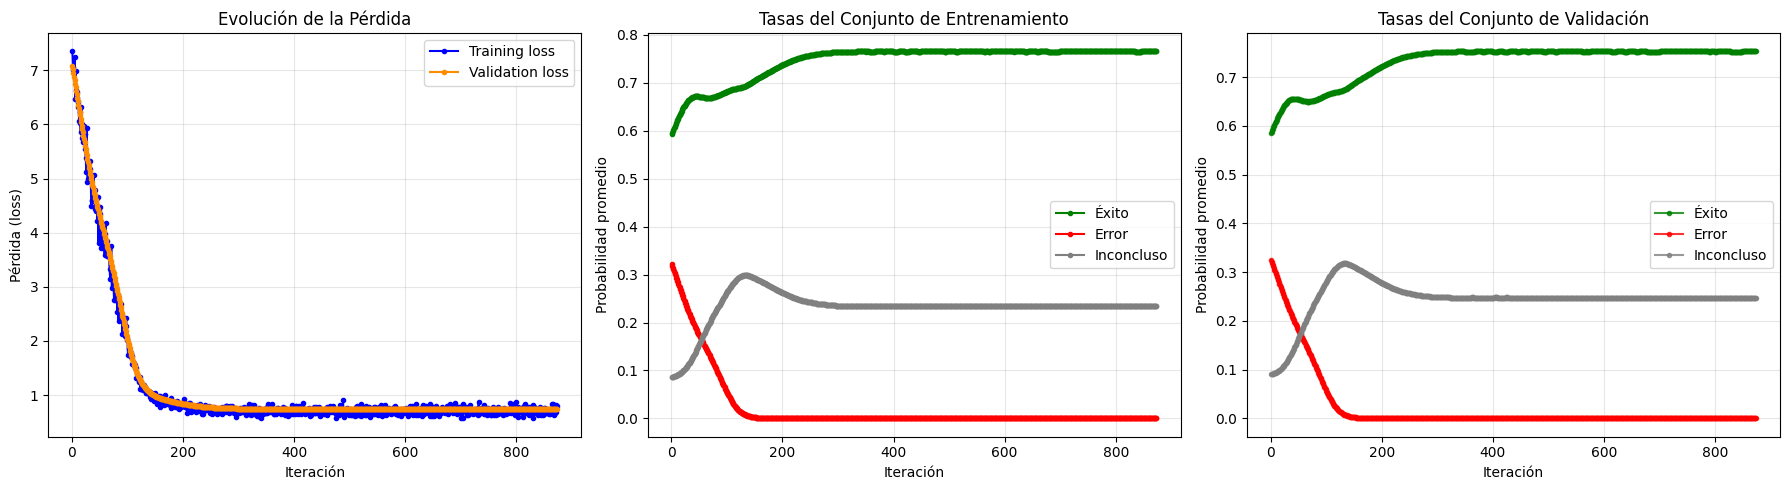

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

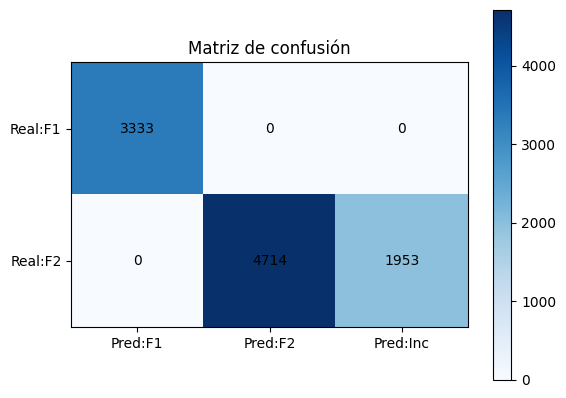

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
